# Car market in Poland
### Exploratory data analysis and car prices prediction
-------------------------------------------------------------------

**Table of Contents:**
1. [Import of libraries and dataset](#import)
2. [Removal of columns and duplicates](#drop)
3. [Processing of locations, publication dates, and currencies](#proc)
4. [Split of the dataset](#split)
5. [Data exploration and visualization](#visualization)
6. [Transformers and pipelines preparation](#preproc)
7. [Model training and tunning](#training)
8. [Model testing](#test)

### 1. Import of libraries and dataset <a name="import"></a>

In [67]:
# Import necessary libraries
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from currency_converter import CurrencyConverter
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from ast import literal_eval

In [68]:
# Search for dataset file path
for dirname, _, filenames in os.walk('.\data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

.\data\Car_sale_ads.csv


In [53]:
# Read dataset, display first rows and basic informations about columns
# Use literal_eval function as a converter for Features column to read values as lists not strings
df_raw = pd.read_csv('.\data\Car_sale_ads.csv', index_col='Index', converters={'Features': literal_eval})
df = df_raw.copy()

In [54]:
df.head()

Price Currency Condition Vehicle_brand Vehicle_model Vehicle_version  \
Index                                                                         
0      86200      PLN       New        Abarth           595             NaN   
1      43500      PLN      Used        Abarth         Other             NaN   
2      44900      PLN      Used        Abarth           500             NaN   
3      39900      PLN      Used        Abarth           500             NaN   
4      97900      PLN       New        Abarth           595             NaN   

      Vehicle_generation  Production_year  Mileage_km  Power_HP  ...  \
Index                                                            ...   
0                    NaN             2021         1.0     145.0  ...   
1                    NaN             1974     59000.0      75.0  ...   
2                    NaN             2018     52000.0     180.0  ...   
3                    NaN             2012     29000.0     160.0  ...   
4                    NaN             2021       600.0     165.0  ...   

       Transmission        Type  Doors_number  Colour Origin_country  \
Index                                                                  
0            Manual  small_cars           3.0    gray            NaN   
1            Manual       coupe           2.0  silver            NaN   
2         Automatic  small_cars           3.0  silver            NaN   
3            Manual  small_cars           3.0    gray            NaN   
4            Manual  small_cars           3.0    blue            NaN   

      First_owner  First_registration_date Offer_publication_date  \
Index                                                               
0             NaN                      NaN             04/05/2021   
1             NaN                      NaN             03/05/2021   
2             NaN                      NaN             03/05/2021   
3             NaN                      NaN             30/04/2021   
4             NaN                      NaN             30/04/2021   

                                          Offer_location  \
Index                                                      
0      ul. Jubilerska 6 - 04-190 Warszawa, Mazowiecki...   
1      kanonierska12 - 04-425 Warszawa, Rembertów (Po...   
2                       Warszawa, Mazowieckie, Białołęka   
3                                      Jaworzno, Śląskie   
4      ul. Gorzysława 9 - 61-057 Poznań, Nowe Miasto ...   

                                                Features  
Index                                                     
0                                                     []  
1                                                     []  
2      [ABS, Electric front windows, Drivers airbag, ...  
3      [ABS, Electric front windows, Drivers airbag, ...  
4      [ABS, Electrically adjustable mirrors, Passeng...  

[5 rows x 24 columns]

In [55]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 208304 entries, 0 to 208303
Data columns (total 24 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   Price                    208304 non-null  int64  
 1   Currency                 208304 non-null  object 
 2   Condition                208304 non-null  object 
 3   Vehicle_brand            208304 non-null  object 
 4   Vehicle_model            208304 non-null  object 
 5   Vehicle_version          138082 non-null  object 
 6   Vehicle_generation       147860 non-null  object 
 7   Production_year          208304 non-null  int64  
 8   Mileage_km               207321 non-null  float64
 9   Power_HP                 207661 non-null  float64
 10  Displacement_cm3         206338 non-null  float64
 11  Fuel_type                208304 non-null  object 
 12  CO2_emissions            94047 non-null   float64
 13  Drive                    193228 non-null  object 
 14  Tran

### 2. Removal of columns and duplicates <a name="drop"></a>

In [56]:
# Convert Doors_number column data type from float to int
# Display percentage of NULL values of each column
df['Doors_number'] = df['Doors_number'].convert_dtypes()
df.isnull().sum() / df.shape[0] * 100

Price                       0.000000
Currency                    0.000000
Condition                   0.000000
Vehicle_brand               0.000000
Vehicle_model               0.000000
Vehicle_version            33.711307
Vehicle_generation         29.017206
Production_year             0.000000
Mileage_km                  0.471906
Power_HP                    0.308683
Displacement_cm3            0.943813
Fuel_type                   0.000000
CO2_emissions              54.851083
Drive                       7.237499
Transmission                0.229952
Type                        0.000000
Doors_number                0.713861
Colour                      0.000000
Origin_country             43.202243
First_owner                68.750480
First_registration_date    58.500557
Offer_publication_date      0.000000
Offer_location              0.000000
Features                    0.000000
dtype: float64

In [57]:
# Drop columns with more than 30% NULL values
threshold = 0.3 * df.shape[0]
cols_to_drop = [col for col in df.columns if df[col].isnull().sum() >= threshold]
df = df.drop(columns=cols_to_drop)
print(f'Dropped columns: {cols_to_drop}')

Dropped columns: ['Vehicle_version', 'CO2_emissions', 'Origin_country', 'First_owner', 'First_registration_date']


In [58]:
# Remove duplicated rows from dataset
duplicates = df.duplicated(subset=df.columns[:-1]).sum()
df = df.drop_duplicates(subset=df.columns[:-1])
print(f'{duplicates} duplicates removed.')

1756 duplicates removed.


### 3. Processing of locations, publication dates, and currencies <a name="proc"></a>

In [66]:
# Extract province name from Offer_location column which contains the whole offer location address
# 'unknown' value is assigned to rows without province name in Offer_location
provinces = ('dolnośląskie', 'kujawsko-pomorskie', 'lubelskie', 'lubuskie', 'łódzkie', 'małopolskie',
             'mazowieckie', 'opolskie', 'podkarpackie', 'podlaskie', 'pomorskie', 'śląskie',
             'świętokrzyskie', 'warmińsko-mazurskie', 'wielkopolskie', 'zachodniopomorskie')

def find_province(x):
    found = [word.lower().strip('-/:,.; ') for word in x.split()
             if word.lower().strip('-/:,.; ') in provinces]
    return found[0] if found else 'unknown'
    
df['Offer_location'] = df['Offer_location'].apply(find_province)
provinces_count = df.groupby('Offer_location').size().sort_values(ascending=False)
fig = px.bar(y=provinces_count.index, x=provinces_count,
             labels={'y': 'Province', 'x': 'Number of adverts'}, template='seaborn', orientation='h')
fig.show()

In [60]:
# Display time interval of offers from dataset
df['Offer_publication_date'] = pd.to_datetime(df['Offer_publication_date'], dayfirst=True)
init_date = df['Offer_publication_date'].min()
final_date = df['Offer_publication_date'].max()
print(f'Adverts dates from {init_date.date()} to {final_date.date()}')

Adverts dates from 2021-03-26 to 2021-05-05


In [61]:
# Display types of currency from offers
df['Currency'].value_counts()

PLN    206302
EUR       246
Name: Currency, dtype: int64

In [62]:
# Convert price from the original currency to USD taking into account the exchange rates
# on the day of offer publication.
# Rename columns
converter = CurrencyConverter(fallback_on_missing_rate=True)

df['Price'] = df.apply(lambda x: converter.convert(x['Price'], x['Currency'],
                                                   'USD', date=x['Offer_publication_date'].date()), axis=1)
df = df.rename(columns={'Price': 'Price_USD', 'Currency': 'Original_currency'})

In [63]:
# Add columns for day and month of offer (not for year since it's always 2021 for all cases)
# Drop original date column
df['Offer_publication_day'] = df['Offer_publication_date'].dt.day
df['Offer_publication_month'] = df['Offer_publication_date'].dt.month
df['Offer_publication_dayofweek'] = df['Offer_publication_date'].dt.dayofweek
df = df.drop(columns=['Offer_publication_date'])

### 4. Split of the dataset <a name="split"></a>

In [64]:
# Split dataset to train and test sets
y = df['Price_USD']
X = df.drop(columns=['Price_USD'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f'Train set size: {len(X_train)}')
print(f'Test set size: {len(X_test)}')

Train set size: 165238
Test set size: 41310


### 5. Data exploration and visualization <a name="visualization"></a>

In [65]:
# Compare the number of cars from different price range
price_bins = [0, 1000, 2500, 5000, 10000, 17500, 30000, 50000, 80000, 120000, np.inf]
price_labels = ['< 1k', '1k to 2.5k', '2.5k to 5k', '5k to 10k', '10k to 17.5k',
                '17.5k to 30k', '30k to 50k', '50k to 80k', '80k to 120k', '> 120k']
price_counts = pd.cut(y_train, bins=price_bins, labels=price_labels)
price_counts = price_counts.groupby(price_counts).size()
fig = px.bar(y=price_counts, x=price_counts.index,
       labels={'y': 'Number of adverts', 'x': 'Car price (USD)'}, template='seaborn')
fig.show()

In [49]:
power_bins = [0, 60, 90, 120, 150, 200, 300, 450, np.inf]
power_labels = ['< 60', '60 to 90', '90 to 120', '120 to 150', '150 to 200', '200 to 300',
                '300 to 450', '> 450']
power_counts = pd.cut(X_train['Power_HP'], bins=power_bins, labels=power_labels)
power_counts = power_counts.groupby(power_counts).size()
fig = px.bar(y=power_counts, x=power_counts.index,
       labels={'y': 'Number of adverts', 'x': 'Car power in HP'}, template='seaborn')
fig.show()

In [18]:
# Compare the number of cars from different production years
production_year_count = X_train.groupby('Production_year').size()
older_sum = production_year_count[production_year_count.index < 2000].sum()
older = pd.Series([older_sum], ['older'])
production_year_count = production_year_count[production_year_count.index >= 2000]
production_year_count = pd.concat([older, production_year_count])
production_year_count.index = [str(idx) for idx in production_year_count.index.values]

fig = px.bar(y=production_year_count.index, x=production_year_count,
       labels={'y': 'Production year', 'x': 'Number of adverts'}, template='seaborn', orientation='h')
fig.show()

In [19]:
# Compare the percentage of cars according to different characteristics:
# condition, transmission, drive, body type and fuel type
cols = ['Condition', 'Transmission', 'Drive', 'Type', 'Fuel_type']
for col in cols:
    col_count = X_train.groupby(col).size()
    fig = px.pie(names=col_count.index, values=col_count,
                 title=f'Proportion of cars {col.lower()}', template='seaborn')
    fig.show()

In [20]:
# Compare the number of cars with different horsepowers
power_bins = [0, 60, 90, 120, 150, 200, 300, 450, np.inf]
power_labels = ['< 60', '60 to 90', '90 to 120', '120 to 150', '150 to 200', '200 to 300',
                '300 to 450', '> 450']
power_counts = pd.cut(X_train['Power_HP'], bins=power_bins, labels=power_labels)
power_counts = power_counts.groupby(power_counts).size()
fig = px.bar(y=power_counts, x=power_counts.index,
       labels={'y': 'Number of adverts', 'x': 'Car power in HP'}, template='seaborn')
fig.show()

In [21]:
# Compare the number of cars with different mileage
mileage_bins = [0, 100, 2000, 10000, 25000, 50000, 100000, 150000, 200000, 250000, 300000, 400000, np.inf]
mileage_labels = ['< 100', '100 to 2000', '2000 to 10000', '10000 to 25000', '25000 to 50000',
                  '50000 to 100000', '100000 to 150000', '150000 to 200000', '200000 to 250000',
                  '250000 to 300000', '300000 to 400000', '> 400000']
mileage_counts = pd.cut(X_train['Mileage_km'], bins=mileage_bins, labels=mileage_labels)
mileage_counts = mileage_counts.groupby(mileage_counts).size()
fig = px.bar(y=mileage_counts, x=mileage_counts.index,
       labels={'y': 'Number of adverts', 'x': 'Car mileage in km'}, template='seaborn')
fig.show()

In [22]:
# Compare the number of cars with different motor sizes
displacement_bins = [1, 1000, 1400, 1800, 2000, 3000, 4500, np.inf]
displacement_labels = ['< 1.0', '1.0 to 1.4', '1.4 to 1.8', '1.8 to 2.0', '2.0 to 3.0',
                       '3.0 to 4.5', '> 4.5']
displacement_counts = pd.cut(X_train['Displacement_cm3'], bins=displacement_bins,
                             labels=displacement_labels)
displacement_counts = displacement_counts.groupby(displacement_counts).size()
fig = px.bar(y=displacement_counts, x=displacement_counts.index,
       labels={'y': 'Number of adverts', 'x': 'Car motor displacement in liters'}, template='seaborn')
fig.show()

In [23]:
# Display number of different car brands, models and generations in train set
print(f'Number of different car brands in train set: {X_train["Vehicle_brand"].nunique()}')
print(f'Number of different car models in train set: {X_train["Vehicle_model"].nunique()}')
print(f'Number of different car generations in train set: {X_train["Vehicle_generation"].nunique()}')

Number of different car brands in train set: 108
Number of different car models in train set: 1168
Number of different car generations in train set: 566


In [24]:
# Show the most frequently posted car brands
brands_count = X_train.groupby('Vehicle_brand').size().sort_values(ascending=False)
other = brands_count[25:].sum()
brands_count = brands_count[:25]
brands_count['other'] = other
fig = px.bar(y=brands_count.index, x=brands_count, labels={'y': 'Vehicle brand', 'x': 'Number of adverts'},
       template='seaborn', orientation='h')
fig.show()

In [25]:
# Show the most frequently posted car models
models_count = X_train.groupby('Vehicle_model').size().sort_values(ascending=False)
models_count = models_count[:25]
fig = px.bar(y=models_count.index, x=models_count, labels={'y': 'Vehicle model', 'x': 'Number of adverts'},
       template='seaborn', orientation='h')
fig.show()

In [26]:
# Show the most frequently posted car model generations
X_train_temp = X_train[['Vehicle_model', 'Vehicle_generation']].copy()
X_train_temp['Vehicle_model_gen'] =  X_train_temp.apply(
    lambda x: '(' + x['Vehicle_model'] + ') ' + x['Vehicle_generation']
    if not pd.isna(x['Vehicle_generation']) else np.nan, axis=1)

generation_count = X_train_temp.groupby('Vehicle_model_gen').size().sort_values(ascending=False)
generation_count = generation_count[:25]
fig = px.bar(y=generation_count.index, x=generation_count,
       labels={'y': 'Vehicle model generation', 'x': 'Number of adverts'},
       template='seaborn', orientation='h')
fig.show()

In [27]:
# Extract and show the most frequent additional cars features
features_dict = dict()
for _, features in X_train['Features'].iteritems():
    for feature in features:
        feature = feature.lower().replace(' ', '_').replace('-', '_')
        if not feature in features_dict.keys():
            features_dict[feature] = 1
        else:
            features_dict[feature] += 1

sorted_features = sorted(features_dict.items(), key=lambda x: x[1], reverse=True)[:25]
names = [name for name, _ in sorted_features]
counts = [count for _, count in sorted_features]

fig = px.bar(y=names, x=counts, labels={'y': 'Additional car feature', 'x': 'Number of adverts'},
       template='seaborn', orientation='h')
fig.show()

### 6. Transformers and pipelines preparation <a name="preproc"></a>

In [28]:
# Define custom column transformer for converting the least frequent categorical feature values
# to one common value to reduce the number of columns after dummy encoding
# Missing values fill with 'Unknown'
# The 'thresh' parameter specifies the minimum number of occurrences of the feature value
# to be included after the transformation

class CarsTransformer(BaseEstimator, TransformerMixin):
    
    def __init__(self, col_name, thresh=50):
        self.values_dict = dict()
        self.thresh = thresh
        self.col_name = col_name
    
    def fit(self, X):
        for _, val in X[self.col_name].iteritems():
            if not val in self.values_dict.keys():
                self.values_dict[val] = 1
            else:
                self.values_dict[val] += 1
        self.most_popular_values = [val for val, count in self.values_dict.items() if count >= self.thresh]
        return self
    
    @staticmethod
    def check_value(value, most_popular_values):
        if pd.isna(value):
            return 'Unknown'
        else:
            return value if value in most_popular_values else 'Other'
    
    def transform(self, X):
        X[self.col_name] = X[self.col_name].apply(CarsTransformer.check_value,
                                                  args=(self.most_popular_values,))
        return X

In [29]:
# Define custom column transformer for extracting additional car features and dummy encoding

class CarFeaturesTransformer(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        self.features_list = list()
    
    def fit(self, X, col_name='Features'):
        for _, features in X[col_name].iteritems():
            for feature in features:
                feature = feature.lower().replace(' ', '_').replace('-', '_')
                if not feature in self.features_list:
                    self.features_list.append(feature)
        return self
    
    @staticmethod
    def check_feature(x, new_feature):
        sample_features = [feature.lower().replace(' ', '_').replace('-', '_') for feature in x]
        return 1 if new_feature in sample_features else 0
    
    def transform(self, X, col_name='Features'):
        X_new = X.copy()
        for new_feature in self.features_list:
            X_new[new_feature] = X_new[col_name].apply(CarFeaturesTransformer.check_feature,
                                                       args=(new_feature,))
        return X_new.drop(columns=[col_name])

In [30]:
# Prepare lists of categorical and numerical columns before performing preprocessing
numerical = X_train.select_dtypes(include=np.number).columns.tolist()
categorical = X_train.select_dtypes(include='object').columns.tolist()
categorical.remove('Features')
numerical.remove('Doors_number')
print(f'Numerical: {numerical}')
print(f'Categorical: {categorical}')

Numerical: ['Production_year', 'Mileage_km', 'Power_HP', 'Displacement_cm3', 'Offer_publication_day', 'Offer_publication_month', 'Offer_publication_dayofweek']
Categorical: ['Original_currency', 'Condition', 'Vehicle_brand', 'Vehicle_model', 'Vehicle_generation', 'Fuel_type', 'Drive', 'Transmission', 'Type', 'Colour', 'Offer_location']


In [31]:
# Display number of NULL values in the remaining columns
X_train.isnull().sum()

Original_currency                  0
Condition                          0
Vehicle_brand                      0
Vehicle_model                      0
Vehicle_generation             47643
Production_year                    0
Mileage_km                       765
Power_HP                         507
Displacement_cm3                1520
Fuel_type                          0
Drive                          11927
Transmission                     385
Type                               0
Doors_number                    1149
Colour                             0
Offer_location                     0
Features                           0
Offer_publication_day              0
Offer_publication_month            0
Offer_publication_dayofweek        0
dtype: int64

In [32]:
# Define separate transformers for different columns:
# for categorical features impute 'unknown' for all missing values and use dummy encoding
# for numerical features use KNNImputer to fill missing values and perform scaling
# to impute missing values in Doors_number use median
# use CarsTransformer to remove infrequent values and fill missing values 
# in Vahicle_brand, Vahicle_model and Vehicle_generation
# use CarFeaturesTransformer to extract end encode additional cars features

cat_pipe = Pipeline([('imputer', SimpleImputer(strategy='constant', fill_value='unknown')),
                     ('encoder', OneHotEncoder(drop='if_binary'))])

num_pipe = Pipeline([('imputer', KNNImputer(n_neighbors=5)),
                    ('scaler', StandardScaler())])

col_transformer = ColumnTransformer([('cat_pipe', cat_pipe, categorical),
                                    ('num_pipe', num_pipe, numerical),
                                    ('doors_imputer', SimpleImputer(strategy='median'), ['Doors_number'])],
                                    remainder='passthrough')

preprocessor = Pipeline([('brand_transformer', CarsTransformer(col_name='Vehicle_brand', thresh=10)),
                         ('model_transformer', CarsTransformer(col_name='Vehicle_model', thresh=10)),
                         ('generation_transformer', CarsTransformer(col_name='Vehicle_generation',
                                                                    thresh=10)),
                         ('features_transformer', CarFeaturesTransformer()),
                         ('col_transformer', col_transformer)])

In [30]:
# Prepare train set
X_train_prep = preprocessor.fit_transform(X_train)
print(f'Prepared data shape: {X_train_prep.shape}')

Prepared data shape: (165238, 1293)


In [31]:
# Extract new features names from nested pipeline
feature_columns = np.array(preprocessor.named_steps['features_transformer'].features_list)
cat_columns = preprocessor.named_steps['col_transformer'].named_transformers_['cat_pipe']\
                    ['encoder'].get_feature_names_out(categorical)

column_names = np.append(cat_columns, np.array(numerical))
column_names = np.append(column_names, np.array(['Doors_number']))
column_names = np.append(column_names, feature_columns)
column_names[:20]

array(['Original_currency_PLN', 'Condition_Used', 'Vehicle_brand_Abarth',
       'Vehicle_brand_Acura', 'Vehicle_brand_Aixam',
       'Vehicle_brand_Alfa Romeo', 'Vehicle_brand_Aston Martin',
       'Vehicle_brand_Audi', 'Vehicle_brand_BMW', 'Vehicle_brand_Bentley',
       'Vehicle_brand_Buick', 'Vehicle_brand_Cadillac',
       'Vehicle_brand_Chevrolet', 'Vehicle_brand_Chrysler',
       'Vehicle_brand_Citroën', 'Vehicle_brand_Cupra',
       'Vehicle_brand_DS Automobiles', 'Vehicle_brand_Dacia',
       'Vehicle_brand_Daewoo', 'Vehicle_brand_Daihatsu'], dtype=object)

### 7. Model training and tunning <a name="training"></a>

In [32]:
# Import libraries
from sklearn.linear_model import Ridge
from sklearn.svm import LinearSVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor

C:\Users\szymo\.conda\envs\Cars_in_Poland\lib\site-packages\xgboost\compat.py:36: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



In [33]:
# Check different models on train set using cross validation and RMSE metric
ridge = Ridge()
svr = LinearSVR()
tree = DecisionTreeRegressor(max_depth=8, min_samples_leaf=5)
xgb = XGBRegressor(max_depth=8, learning_rate=0.1)
models = [ridge, svr, tree, xgb]

for model in models:
    scores = cross_val_score(model, X_train_prep, y_train,
                            scoring="neg_mean_squared_error", cv=5)
    rmse_scores = np.sqrt(-scores)
    print(f'{model.__class__.__name__} mean RMSE score: {rmse_scores.mean()}')

Ridge mean RMSE score: 11175.288273496084
LinearSVR mean RMSE score: 17484.431065132947
DecisionTreeRegressor mean RMSE score: 10490.086239781307
XGBRegressor mean RMSE score: 8384.873807634367


In [34]:
# Search for an optimal number of trees using early stopping
X_train2, X_eval, y_train2, y_eval = train_test_split(X_train_prep, y_train, test_size=0.2,
                                                      random_state=42)
eval_set = [(X_train2, y_train2), (X_eval, y_eval)]

model = XGBRegressor(n_estimators=1000, learning_rate=0.1, max_depth=8, subsample=0.8,
                     colsample_bytree=0.8)
model.fit(X_train2, y_train2, eval_metric='rmse', eval_set=eval_set,
          verbose=True, early_stopping_rounds=50)

[0]	validation_0-rmse:26548.87695	validation_1-rmse:26085.00977
[1]	validation_0-rmse:24314.58398	validation_1-rmse:23813.89648
[2]	validation_0-rmse:22276.72852	validation_1-rmse:21833.15625
[3]	validation_0-rmse:20470.97070	validation_1-rmse:20007.55273
[4]	validation_0-rmse:18799.75586	validation_1-rmse:18367.39648
[5]	validation_0-rmse:17302.31055	validation_1-rmse:16917.01953
[6]	validation_0-rmse:15965.75684	validation_1-rmse:15635.36621
[7]	validation_0-rmse:14776.39062	validation_1-rmse:14520.27344
[8]	validation_0-rmse:13752.92285	validation_1-rmse:13511.59961
[9]	validation_0-rmse:12844.04199	validation_1-rmse:12611.78906
[10]	validation_0-rmse:12023.03711	validation_1-rmse:11841.93945
[11]	validation_0-rmse:11249.66602	validation_1-rmse:11140.68457
[12]	validation_0-rmse:10638.43555	validation_1-rmse:10557.46680
[13]	validation_0-rmse:10096.43457	validation_1-rmse:10016.62793
[14]	validation_0-rmse:9585.12793	validation_1-rmse:9571.98633
[15]	validation_0-rmse:9148.36426	val

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_delta_step=0,
             max_depth=8, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=12,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=0.8,
             tree_method='exact', validate_parameters=1, verbosity=None)

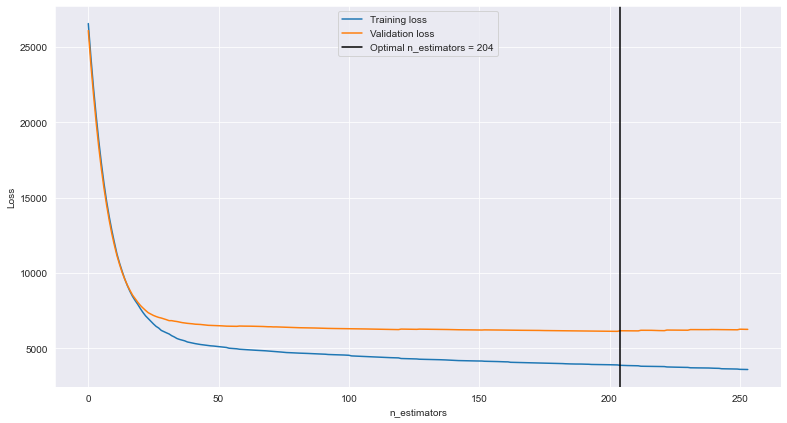

In [35]:
# Show learning curve and optimal value for n_estimators hyperparameter
results = model.evals_result()
best_n = model.best_ntree_limit

sns.set_style('darkgrid')
plt.figure(figsize=(13, 7))
plt.plot(results["validation_0"]["rmse"], label="Training loss")
plt.plot(results["validation_1"]["rmse"], label="Validation loss")
plt.axvline(best_n, color="black", label=f'Optimal n_estimators = {best_n}')
plt.xlabel("n_estimators")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [36]:
# Use grid search to find the optimal depth of trees
params = {'max_depth': np.arange(6, 15, 1)}

model = XGBRegressor(n_estimators=best_n, learning_rate=0.1, max_depth=8, subsample=0.8,
                     colsample_bytree=0.8)
grid_search = GridSearchCV(estimator=model, param_grid=params, n_jobs=-1,
                           scoring='neg_mean_squared_error', cv=5, verbose=1)
grid_search.fit(X_train_prep, y_train)
print(f'Best params: {grid_search.best_params_}')

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best params: {'max_depth': 10}


In [37]:
# Tune hyperparameters that allow avoiding overfitting using RandomizedSearchCV
params = {'learning_rate': [0.001, 0.003, 0.01, 0.03, 0.1, 0.3],
          'subsample': np.arange(0.6, 0.85, 0.05),
          'colsample_bytree': np.arange(0.6, 0.85, 0.05),
          'min_child_weight': np.arange(1, 6, 2),
          'gamma': np.arange(0, 1, 0.1)} 

model = grid_search.best_estimator_
random_search = RandomizedSearchCV(estimator=model, param_distributions=params, n_iter=50, n_jobs=-1,
                                   scoring='neg_mean_squared_error', cv=5, verbose=1)
random_search.fit(X_train_prep, y_train)
print(f'Best params: {random_search.best_params_}')

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best params: {'subsample': 0.7500000000000001, 'min_child_weight': 1, 'learning_rate': 0.1, 'gamma': 0.8, 'colsample_bytree': 0.7500000000000001}


In [89]:
# Extract the best estimator from random search and show features that were most valuable
# in construction of the boosted decision trees
model = random_search.best_estimator_
sorted_idx = model.feature_importances_.argsort()
fig = px.bar(y=column_names[sorted_idx][-25:], x=model.feature_importances_[sorted_idx][-25:],
       labels={'y': 'Feature name', 'x': 'Feature importance'}, template='seaborn', orientation='h')
fig.show()

### 8. Model testing <a name="test"></a>

In [39]:
# Prepare test set
X_test_prep = preprocessor.transform(X_test)
print(f'Prepared test data shape: {X_test_prep.shape}')

Prepared test data shape: (41310, 1293)


In [40]:
# Use model to predict prices on test set and evaluate it using RMSE and R2 score
y_pred = model.predict(X_test_prep)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)
print(f'RMSE score on test set: {rmse}')
print(f'R2 score on test set: {r2}')

RMSE score on test set: 5252.910707509101
R2 score on test set: 0.9440663338363763


In [91]:
# Calculate prediction error and show comparison of predictions and actual prices on scatter plot
results = pd.DataFrame(data={'Predicted_price': y_pred,
                             'Actual_price': y_test.values,
                             'Vehicle_brand': X_test['Vehicle_brand'].values})
results['Error'] = results['Actual_price'] - results['Predicted_price']

x = y = [0, results['Actual_price'].max()]
fig = px.scatter(results, x='Actual_price', y='Predicted_price', color='Vehicle_brand', opacity=0.6,
                 labels={'Actual_price': 'Actual price (USD)', 'Predicted_price': 'Predicted price (USD)'})
fig.add_trace(go.Scatter(x=x, y=y, mode="lines", line=go.scatter.Line(color="red", width=4),
                         showlegend=False))
fig.update_layout(
    title={'text': f'RMSE = {rmse:.3f}    R2 = {r2:.3f}', 'x':0.5})
fig.show()

In [93]:
# Plot histogram of prediction errors
fig = px.histogram(results, x='Error', range_x=(-30000, 30000))
fig.update_layout(title={'text': 'Histogram of prediction errors', 'x': 0.5},
                  yaxis_title='Frequency',
                  xaxis_title='Price prediction error (USD)')
fig.show()

In [45]:
# Save model to file
import pickle

pickle.dump(model, open('model.pickle', "wb"))

In [46]:
# Load model from file
# model_loaded = pickle.load(open('model.pickle', "rb"))
# model_loaded.get_xgb_params